In [ ]:
import os
import numpy as np
import pandas as pd
import mne 



fifFileHcEpochPath = "/Users/wachiii/Workschii/brain-mdd/data-modma/balanced16preprocess/hc1624preprocessed.fif"
fifFileMddEpochPath = "/Users/wachiii/Workschii/brain-mdd/data/balanced16preprocess/mdd1624preprocessed.fif"   

allFeatureDirPath = "/Users/wachiii/Workschii/brain-mdd/data/balancedfeatures"


## Preprocessing
- bandpass filter 0.5 - 40 Hz
- Epoching for 10 sec => 10*250 = 2500 samples

In [ ]:
# do preprocessing: bandpass filter 0.5 - 40 Hz
mddEeg = mddRaw.load_data()
hcEeg = hcRaw.load_data()

mddEeg.filter(0.5, 40, fir_design='firwin')
hcEeg.filter(0.5, 40, fir_design='firwin')

# plot psd only 1 channel
mddEeg.plot_psd(fmin=0.5, fmax=40, average=True, spatial_colors=True) 
hcEeg.plot_psd(fmin=0.5, fmax=40, average=True, spatial_colors=True)

# do epoching; fs = 250, total samples = 1784136 where 1784136/24 = 74339.0 samples per subject -> i want epoch for 10 seconds
# 10 seconds = 2500 samples

mddEpochs = mne.make_fixed_length_epochs(mddEeg, duration=10, preload=True)
hcEpochs = mne.make_fixed_length_epochs(hcEeg, duration=10, preload=True)

print(mddEpochs)
print(hcEpochs)

# mddEpochs.save("/Users/wachiii/Workschii/brain-mdd/data/balanced16preprocess/mdd1624preprocessed.fif", overwrite=True)
# hcEpochs.save("/Users/wachiii/Workschii/brain-mdd/data/balanced16preprocess/hc1624preprocessed.fif", overwrite=True)

In [ ]:
74339.0/(10*250)

## Feature Extraction

### 1. Band Power - PSD

In [ ]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.psd import EEGPowerSpectrum
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250


# Declare Feature Dictionary
featureDict = {
    "norm_power": {
        "mdd": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            },
        "control": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            }
        }
    }    

In [ ]:
# Load the epochs
mddEpochs = mne.read_epochs(fifFileMddEpochPath)
hcEpochs = mne.read_epochs(fifFileHcEpochPath)

print(len(mddEpochs))
print(len(hcEpochs))

print(mddEpochs.get_data()[0].shape)
print(hcEpochs.get_data()[0].shape)

In [ ]:
psdObjMdd = EEGPowerSpectrum(mddEpochs, 250, ifNormalize=False)
mddPsdFeatures = psdObjMdd.run()
psdObjCtrl = EEGPowerSpectrum(hcEpochs, 250, ifNormalize=False)
hcPsdFeatures = psdObjCtrl.run()
print(mddPsdFeatures.shape)
print(hcPsdFeatures.shape)

In [ ]:
# save at allFeatureDirPath + /psd
np.save(allFeatureDirPath + "/bandpower/mddBandpowerFeatures.npy", mddPsdFeatures)
np.save(allFeatureDirPath + "/bandpower/hcBandpowerFeatures.npy", hcPsdFeatures)

### 2. Relative Power

In [ ]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.psd import EEGPowerSpectrum
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250


# Declare Feature Dictionary
featureDict = {
    "norm_power": {
        "mdd": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            },
        "control": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            }
        }
    }    

In [ ]:
# Load the epochs
mddEpochs = mne.read_epochs(fifFileMddEpochPath)
hcEpochs = mne.read_epochs(fifFileHcEpochPath)

print(len(mddEpochs))
print(len(hcEpochs))

print(mddEpochs.get_data()[0].shape)
print(hcEpochs.get_data()[0].shape)

In [ ]:
psdObjMdd = EEGPowerSpectrum(mddEpochs, 250, ifNormalize=True)
mddPsdFeatures = psdObjMdd.run()
psdObjCtrl = EEGPowerSpectrum(hcEpochs, 250, ifNormalize=True)
hcPsdFeatures = psdObjCtrl.run()
print(mddPsdFeatures.shape)
print(hcPsdFeatures.shape)

In [ ]:
# save at allFeatureDirPath + /psd
np.save(allFeatureDirPath + "/relativepower/mddRelativepowerFeatures.npy", mddPsdFeatures)
np.save(allFeatureDirPath + "/relativepower/hcRelativepowerFeatures.npy", hcPsdFeatures)

### 3. HFD

In [ ]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.hfd import EEGHiguchiFractalDimension
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250


# Declare Feature Dictionary
featureDict = {
    "HFD": {
        "mdd": [],
        "control": []
    }
}

In [ ]:
# Load the epochs
mddEpochs = mne.read_epochs(fifFileMddEpochPath)
hcEpochs = mne.read_epochs(fifFileHcEpochPath)
mddEpochs = mddEpochs.get_data()
hcEpochs = hcEpochs.get_data()
print(mddEpochs.shape)
print(hcEpochs.shape)

In [ ]:
hfdObjMdd = EEGHiguchiFractalDimension(mddEpochs)
mddHfdFeatures = hfdObjMdd.run()
hfdObjControl = EEGHiguchiFractalDimension(hcEpochs)
hcHfdFeatures = hfdObjControl.run()

print(mddHfdFeatures.shape)
print(hcHfdFeatures.shape)

In [ ]:
# save at allFeatureDirPath + /psd
np.save(allFeatureDirPath + "/hfd/mddHfdFeatures.npy", mddHfdFeatures)
np.save(allFeatureDirPath + "/hfd/hcHfdFeatures.npy", hcHfdFeatures)

### 4. Coherences

In [ ]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.coherence import EEGCoherence
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9 
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250


# Declare Feature Dictionary
featureDict = {
    "coherence": {
        "mdd": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            },
        "control": {
            "delta": [],
            "theta": [],
            "alpha": [],
            "beta": [],
            "gamma": []
            }
        }
    } 


In [ ]:
mddEpochs = mne.read_epochs(fifFileMddEpochPath)
mddEpochs = mddEpochs.get_data()
# print paired channels
coherenceObjMdd = EEGCoherence(mddEpochs, MODMA_SFREQ)
print(coherenceObjMdd.channel_pairs)

In [ ]:
mddEpochs = mne.read_epochs(fifFileMddEpochPath)
hcEpochs = mne.read_epochs(fifFileHcEpochPath)
mddEpochs = mddEpochs.get_data()
hcEpochs = hcEpochs.get_data()
print(mddEpochs.shape)
print(hcEpochs.shape)

In [ ]:
coherenceObjMdd = EEGCoherence(mddEpochs, MODMA_SFREQ)
mddCohFeatures = coherenceObjMdd.run()
coherenceObjControl = EEGCoherence(hcEpochs, MODMA_SFREQ)
hcCohFeatures = coherenceObjControl.run()

print(mddCohFeatures.shape)
print(hcCohFeatures.shape)

In [ ]:
# save at allFeatureDirPath + /psd
np.save(allFeatureDirPath + "/coh/mddCohFeatures.npy", mddCohFeatures)
np.save(allFeatureDirPath + "/coh/hcCohFeatures.npy", hcCohFeatures)

### 5. Cd

In [ ]:
import dotenv
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from brainmdd.features.correlationdimension import EEGCorrelationDimension
import mne
import enum

dotenv.load_dotenv()

class ChannelMapping(enum.Enum):
    Fp1 = 22
    Fp2 = 9
    F3 = 24
    F4 = 124
    C3 = 36
    C4 = 104
    P3 = 52
    P4 = 92
    O1 = 70
    O2 = 83
    F7 = 33
    F8 = 122
    T3 = 45
    T4 = 108
    T5 = 58
    T6 = 96

# Declare Global Variables
NUM_CHANNELS = 16
MODMA_SFREQ = 250


# Declare Feature Dictionary
featureDict = {
    "CD": {
        "mdd": [],
        "control": []
    }
}

In [ ]:
mddEpochs = mne.read_epochs(fifFileMddEpochPath)
hcEpochs = mne.read_epochs(fifFileHcEpochPath)
mddEpochs = mddEpochs.get_data()
hcEpochs = hcEpochs.get_data()
print(mddEpochs.shape)
print(hcEpochs.shape)

In [ ]:
cdObjMdd = EEGCorrelationDimension(mddEpochs)
mddCdFeatures = cdObjMdd.run()
cdObjControl = EEGCorrelationDimension(hcEpochs)
hcCdFeatures = cdObjControl.run()

for epoch in mddCdFeatures:
    featureDict["CD"]["mdd"].append(epoch)
for epoch in hcCdFeatures:
    featureDict["CD"]["control"].append(epoch)

In [ ]:
# save at allFeatureDirPath + /psd
np.save(allFeatureDirPath + "/cd/mddCdFeatures.npy", mddCdFeatures)
np.save(allFeatureDirPath + "/cd/hcCdFeatures.npy", hcCdFeatures)

## Feature Selection & ML

In [4]:
import os
import numpy as np
import joblib
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

import dotenv
import warnings

dotenv.load_dotenv()
warnings.filterwarnings("ignore")


allFeatureDirPath = os.getenv("BALANCED_FEATURES_DIR_PATH")
modelCrossValDirPath = os.getenv("CD_FEATURES_CV_DIR_PATH")         # CHANGE PATH TO SAVE MODEL CROSS VALIDATION HERE!!!!

hcPsdFeatures = np.load(allFeatureDirPath + "/bandpower/hcBandpowerFeatures.npy")
mddPsdFeatures = np.load(allFeatureDirPath + "/bandpower/mddBandpowerFeatures.npy")
hcRelativepowerFeatures = np.load(allFeatureDirPath + "/relativepower/hcRelativepowerFeatures.npy")
mddRelativepowerFeatures = np.load(allFeatureDirPath + "/relativepower/mddRelativepowerFeatures.npy")
hcCohFeatures = np.load(allFeatureDirPath + "/coh/hcCohFeatures.npy")
mddCohFeatures = np.load(allFeatureDirPath + "/coh/mddCohFeatures.npy")
hcHfdFeatures = np.load(allFeatureDirPath + "/hfd/hcHfdFeatures.npy")
mddHfdFeatures = np.load(allFeatureDirPath + "/hfd/mddHfdFeatures.npy")
hcCdFeatures = np.load(allFeatureDirPath + "/cd/hcCdFeatures.npy")
mddCdFeatures = np.load(allFeatureDirPath + "/cd/mddCdFeatures.npy")

print(f"hc psd feature shape: {hcPsdFeatures.shape}")
print(f"mdd psd feature shape: {mddPsdFeatures.shape}")
print(f"relative power hc feature shape: {hcRelativepowerFeatures.shape}")
print(f"relative power mdd feature shape: {mddRelativepowerFeatures.shape}")
print(f"hc coh feature shape: {hcCohFeatures.shape}")
print(f"mdd coh feature shape: {mddCohFeatures.shape}")
print(f"hc hfd feature shape: {hcHfdFeatures.shape}")
print(f"mdd hfd feature shape: {mddHfdFeatures.shape}")
print(f"hc cd feature shape: {hcCdFeatures.shape}")
print(f"mdd cd feature shape: {mddCdFeatures.shape}")

hc psd feature shape: (713, 5, 16)
mdd psd feature shape: (713, 5, 16)
relative power hc feature shape: (713, 5, 16)
relative power mdd feature shape: (713, 5, 16)
hc coh feature shape: (713, 5, 120)
mdd coh feature shape: (713, 5, 120)
hc hfd feature shape: (713, 16)
mdd hfd feature shape: (713, 16)
hc cd feature shape: (713, 16)
mdd cd feature shape: (713, 16)


In [35]:
# Flatten features to make the shape consistent
hcPsdFeatures = hcPsdFeatures.reshape(hcPsdFeatures.shape[0], -1)  # Flatten to (samples, features)
hcRelativepowerFeatures = hcRelativepowerFeatures.reshape(hcRelativepowerFeatures.shape[0], -1)
hcCohFeatures = hcCohFeatures.reshape(hcCohFeatures.shape[0], -1)
hcHfdFeatures = hcHfdFeatures.reshape(hcHfdFeatures.shape[0], -1)
hcCdFeatures = hcCdFeatures.reshape(hcCdFeatures.shape[0], -1)

mddPsdFeatures = mddPsdFeatures.reshape(mddPsdFeatures.shape[0], -1)
mddRelativepowerFeatures = mddRelativepowerFeatures.reshape(mddRelativepowerFeatures.shape[0], -1)
mddCohFeatures = mddCohFeatures.reshape(mddCohFeatures.shape[0], -1)
mddHfdFeatures = mddHfdFeatures.reshape(mddHfdFeatures.shape[0], -1)
mddCdFeatures = mddCdFeatures.reshape(mddCdFeatures.shape[0], -1)

print(f"hc psd feature shape: {hcPsdFeatures.shape}")
print(f"mdd psd feature shape: {mddPsdFeatures.shape}")
print(f"relative power hc feature shape: {hcRelativepowerFeatures.shape}")
print(f"relative power mdd feature shape: {mddRelativepowerFeatures.shape}")
print(f"hc coh feature shape: {hcCohFeatures.shape}")
print(f"mdd coh feature shape: {mddCohFeatures.shape}")
print(f"hc hfd feature shape: {hcHfdFeatures.shape}")
print(f"mdd hfd feature shape: {mddHfdFeatures.shape}")
print(f"hc cd feature shape: {hcCdFeatures.shape}")
print(f"mdd cd feature shape: {mddCdFeatures.shape}")

hc psd feature shape: (713, 80)
mdd psd feature shape: (713, 80)
relative power hc feature shape: (713, 80)
relative power mdd feature shape: (713, 80)
hc coh feature shape: (713, 600)
mdd coh feature shape: (713, 600)
hc hfd feature shape: (713, 16)
mdd hfd feature shape: (713, 16)
hc cd feature shape: (713, 16)
mdd cd feature shape: (713, 16)


In [5]:
models = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance"]}),
    "SVM": (SVC(probability=True, random_state=42), paramGrid),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [5, 10, 15]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [10, 20]}),
    "Logistic Regression": (LogisticRegression(), {"C": [0.01, 0.1, 1]})
}

featureSelectors = {
    "NoFeatureSelection": None,
    "SelectKBest": SelectKBest(score_func=f_classif, k=100),
}

def get_stratified_kfold_data(X, y, nSplits=5):
    skf = StratifiedKFold(n_splits=nSplits, shuffle=True, random_state=42)
    return skf.split(X, y)

NameError: name 'paramGrid' is not defined

In [42]:
# hcFeatures = np.concatenate([
#             hcPsdFeatures, hcRelativepowerFeatures, hcCohFeatures, hcHfdFeatures, hcCdFeatures
#             ], axis=1)  
# mddFeatures = np.concatenate([
#             mddPsdFeatures, mddRelativepowerFeatures, mddCohFeatures, mddHfdFeatures, mddCdFeatures
#             ], axis=1)


hcFeatures = np.concatenate([hcPsdFeatures], axis=1)

mddFeatures = np.concatenate([mddPsdFeatures], axis=1)


X = np.concatenate([hcFeatures, mddFeatures], axis=0)
y = np.concatenate([
    np.zeros(hcPsdFeatures.shape[0]),
    np.ones(mddPsdFeatures.shape[0])   
])

print(f"X shape: {X.shape}")  
print(f"y shape: {y.shape}")

X shape: (1426, 80)
y shape: (1426,)


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns



totalHcTrain = 0
totalMddTrain = 0
totalHcVal = 0
totalMddVal = 0
totalHcTest = 0
totalMddTest = 0

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

np.save(os.path.join(modelCrossValDirPath, "X_test.npy"), X_test)
np.save(os.path.join(modelCrossValDirPath, "y_test.npy"), y_test)

results = []

for modelName, (model, paramGrid) in models.items():
    for featureSelectorName, featureSelector in featureSelectors.items():
        print(f"Training {modelName} with {featureSelectorName}...")
        if featureSelector is not None:
            selector = featureSelector
        else:
            selector = None
        foldAccuracies = []
        foldPrecisions = []
        foldRecalls = []
        foldF1Scores = []
        selectedFeatures = []
        foldHcTrain = []
        foldMddTrain = []
        foldHcVal = []
        foldMddVal = []
        foldHcTest = []
        foldMddTest = []
        foldMetrics = []

        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        best_fold = None
        best_f1_score = -np.inf
        best_fold_model = None

        for fold, (trainIdx, valIdx) in enumerate(skf.split(X_train_val, y_train_val)):
            XTrain, XVal = X_train_val[trainIdx], X_train_val[valIdx]
            yTrain, yVal = y_train_val[trainIdx], y_train_val[valIdx]
            
            hcTrain = int(np.sum(yTrain == 0))
            mddTrain = int(np.sum(yTrain == 1))
            hcVal = int(np.sum(yVal == 0))
            mddVal = int(np.sum(yVal == 1))
            hcTest = int(np.sum(y_test == 0))
            mddTest = int(np.sum(y_test == 1))
            
            foldHcTrain.append(hcTrain)
            foldMddTrain.append(mddTrain)
            foldHcVal.append(hcVal)
            foldMddVal.append(mddVal)
            foldHcTest.append(hcTest)
            foldMddTest.append(mddTest)

            if selector is not None:
                XTrain = selector.fit_transform(XTrain, yTrain)
                XVal = XVal[:, selector.get_support()]
            
            model.fit(XTrain, yTrain)
            
            yPred = model.predict(XVal)
            acc = accuracy_score(yVal, yPred)
            prec = precision_score(yVal, yPred)
            rec = recall_score(yVal, yPred)
            f1 = f1_score(yVal, yPred)
            
            foldAccuracies.append(float(acc)) 
            foldPrecisions.append(float(prec)) 
            foldRecalls.append(float(rec))  
            foldF1Scores.append(float(f1)) 
            
            foldMetrics.append({
                "fold": fold + 1,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1_score": f1,
                "hc_train": hcTrain,
                "mdd_train": mddTrain,
                "hc_val": hcVal,
                "mdd_val": mddVal,
                "hc_test": hcTest,
                "mdd_test": mddTest
            })
            
            if selector is not None:
                selectedFeatures.append(np.where(selector.get_support())[0].tolist())

            model_dir = os.path.join(modelCrossValDirPath, f"{modelName}_{featureSelectorName}")
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            
            model_filename = os.path.join(model_dir, f"model_fold_{fold + 1}.pkl")
            joblib.dump(model, model_filename)
            print(f"Model for fold {fold + 1} saved to {model_filename}")

            if f1 > best_f1_score:
                best_f1_score = f1
                best_fold = fold
                best_fold_model = model

        print(f"Best fold: {best_fold + 1} with F1 score: {best_f1_score:.4f}")

        if selector is not None:
            X_train_val_selected = selector.fit_transform(X_train_val, y_train_val)
            X_test_selected = X_test[:, selector.get_support()]
        else:
            X_train_val_selected = X_train_val
            X_test_selected = X_test
        
        best_fold_model.fit(X_train_val_selected, y_train_val)
        yTestPred = best_fold_model.predict(X_test_selected)
        finalAccuracy = accuracy_score(y_test, yTestPred)
        finalPrecision = precision_score(y_test, yTestPred)
        finalRecall = recall_score(y_test, yTestPred)
        finalF1 = f1_score(y_test, yTestPred)

        # ROC Curve and Confusion Matrix
        y_prob = best_fold_model.predict_proba(X_test_selected)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        
        ax[0].plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f}')
        ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('ROC Curve')
        ax[0].legend(loc='lower right')
        
        cm = confusion_matrix(y_test, yTestPred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['HC', 'MDD'], yticklabels=['HC', 'MDD'], ax=ax[1])
        ax[1].set_xlabel('Predicted Label')
        ax[1].set_ylabel('True Label')
        ax[1].set_title('Confusion Matrix')
        
        plot_filename = os.path.join(modelCrossValDirPath, f"{best_fold}_{modelName}_{featureSelectorName}.png")
        plt.savefig(plot_filename)
        plt.close()

        print(f"Saved evaluation plots: {plot_filename}")

        # Existing results appending code


Training KNN with NoFeatureSelection...
Model for fold 1 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_1.pkl
Model for fold 2 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_2.pkl
Model for fold 3 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_3.pkl
Model for fold 4 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_4.pkl
Model for fold 5 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_5.pkl
Model for fold 6 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_6.pkl
Model for fold 7 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_7.pkl
Model for fold 8 saved to /Users/wachiii/Workschii/brain-

In [5]:
totalHcTrain = 0
totalMddTrain = 0
totalHcVal = 0
totalMddVal = 0
totalHcTest = 0
totalMddTest = 0

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

np.save(os.path.join(modelCrossValDirPath, "X_test.npy"), X_test)
np.save(os.path.join(modelCrossValDirPath, "y_test.npy"), y_test)

results = []

for modelName, (model, paramGrid) in models.items():
    for featureSelectorName, featureSelector in featureSelectors.items():
        print(f"Training {modelName} with {featureSelectorName}...")
        if featureSelector is not None:
            selector = featureSelector
        else:
            selector = None
        foldAccuracies = []
        foldPrecisions = []
        foldRecalls = []
        foldF1Scores = []
        selectedFeatures = []
        foldHcTrain = []
        foldMddTrain = []
        foldHcVal = []
        foldMddVal = []
        foldHcTest = []
        foldMddTest = []
        foldMetrics = []

        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        best_fold = None
        best_f1_score = -np.inf
        best_fold_model = None

        for fold, (trainIdx, valIdx) in enumerate(skf.split(X_train_val, y_train_val)):
            XTrain, XVal = X_train_val[trainIdx], X_train_val[valIdx]
            yTrain, yVal = y_train_val[trainIdx], y_train_val[valIdx]
            
            hcTrain = int(np.sum(yTrain == 0))
            mddTrain = int(np.sum(yTrain == 1))
            hcVal = int(np.sum(yVal == 0))
            mddVal = int(np.sum(yVal == 1))
            hcTest = int(np.sum(y_test == 0))
            mddTest = int(np.sum(y_test == 1))
            
            foldHcTrain.append(hcTrain)
            foldMddTrain.append(mddTrain)
            foldHcVal.append(hcVal)
            foldMddVal.append(mddVal)
            foldHcTest.append(hcTest)
            foldMddTest.append(mddTest)

            if selector is not None:
                XTrain = selector.fit_transform(XTrain, yTrain)
                XVal = XVal[:, selector.get_support()]
            
            model.fit(XTrain, yTrain)
            
            yPred = model.predict(XVal)
            acc = accuracy_score(yVal, yPred)
            prec = precision_score(yVal, yPred)
            rec = recall_score(yVal, yPred)
            f1 = f1_score(yVal, yPred)
            
            foldAccuracies.append(float(acc)) 
            foldPrecisions.append(float(prec)) 
            foldRecalls.append(float(rec))  
            foldF1Scores.append(float(f1)) 
            
            foldMetrics.append({
                "fold": fold + 1,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1_score": f1,
                "hc_train": hcTrain,
                "mdd_train": mddTrain,
                "hc_val": hcVal,
                "mdd_val": mddVal,
                "hc_test": hcTest,
                "mdd_test": mddTest
            })
            
            if selector is not None:
                selectedFeatures.append(np.where(selector.get_support())[0].tolist())

            model_dir = os.path.join(modelCrossValDirPath, f"{modelName}_{featureSelectorName}")
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            
            model_filename = os.path.join(model_dir, f"model_fold_{fold + 1}.pkl")
            joblib.dump(model, model_filename)
            print(f"Model for fold {fold + 1} saved to {model_filename}")

            if f1 > best_f1_score:
                best_f1_score = f1
                best_fold = fold
                best_fold_model = model

        print(f"Best fold: {best_fold + 1} with F1 score: {best_f1_score:.4f}")

        if selector is not None:
            X_train_val_selected = selector.fit_transform(X_train_val, y_train_val)
            X_test_selected = X_test[:, selector.get_support()]
        else:
            X_train_val_selected = X_train_val
            X_test_selected = X_test
        
        best_fold_model.fit(X_train_val_selected, y_train_val)
        yTestPred = best_fold_model.predict(X_test_selected)
        finalAccuracy = accuracy_score(y_test, yTestPred)
        finalPrecision = precision_score(y_test, yTestPred)
        finalRecall = recall_score(y_test, yTestPred)
        finalF1 = f1_score(y_test, yTestPred)

        results.append({
            "model": modelName,
            "feature_selection": featureSelectorName,
            "avg_accuracy": f"{np.mean(foldAccuracies):.4f} ± {np.std(foldAccuracies):.4f}",
            "avg_precision": f"{np.mean(foldPrecisions):.4f} ± {np.std(foldPrecisions):.4f}",
            "avg_recall": f"{np.mean(foldRecalls):.4f} ± {np.std(foldRecalls):.4f}",
            "avg_f1_score": f"{np.mean(foldF1Scores):.4f} ± {np.std(foldF1Scores):.4f}",
            "final_accuracy": f"{finalAccuracy:.4f}",
            "final_precision": f"{finalPrecision:.4f}",
            "final_recall": f"{finalRecall:.4f}",
            "final_f1_score": f"{finalF1:.4f}",
            "significant_features": np.unique([item for sublist in selectedFeatures for item in sublist]).tolist(),
            "folds_accuracy": foldAccuracies,
            "folds_precision": foldPrecisions,
            "folds_recall": foldRecalls,
            "folds_f1_score": foldF1Scores,
            "fold_hc_train": [int(x) for x in foldHcTrain], 
            "fold_mdd_train": [int(x) for x in foldMddTrain],  
            "fold_hc_val": [int(x) for x in foldHcVal], 
            "fold_mdd_val": [int(x) for x in foldMddVal],  
            "fold_hc_test": [int(x) for x in foldHcTest],  
            "fold_mdd_test": [int(x) for x in foldMddTest]  
        })

results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(modelCrossValDirPath, "results.csv"), index=False)
results_df.to_excel(os.path.join(modelCrossValDirPath, "results.xlsx"), index=False)

for result in results:
    print(f"\n{result['model']} with {result['feature_selection']} - Final evaluation")
    print(f"Final Accuracy: {result['final_accuracy']}")
    print(f"Final Precision: {result['final_precision']}")
    print(f"Final Recall: {result['final_recall']}")
    print(f"Final F1 Score: {result['final_f1_score']}")
    print(f"Folds Accuracy: {result['folds_accuracy']}")
    print(f"Folds Precision: {result['folds_precision']}")
    print(f"Folds Recall: {result['folds_recall']}")
    print(f"Folds F1 Score: {result['folds_f1_score']}")

Training KNN with NoFeatureSelection...
Model for fold 1 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_1.pkl
Model for fold 2 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_2.pkl
Model for fold 3 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_3.pkl
Model for fold 4 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_4.pkl
Model for fold 5 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_5.pkl
Model for fold 6 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_6.pkl
Model for fold 7 saved to /Users/wachiii/Workschii/brain-mdd/models/CrossValidation/cdCv/KNN_NoFeatureSelection/model_fold_7.pkl
Model for fold 8 saved to /Users/wachiii/Workschii/brain-

ValueError: No feature in X meets the variance threshold 0.01000

## Final Evaluation

In [2]:
import os
import numpy as np
import joblib
import pandas as pd
from tqdm import tqdm
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [ ]:
allFeatBestModelPath = "/Users/wachiii/Workschii/brain-mdd/models/CrossValidation/allfeatureCv/Random Forest_SelectKBest/model_fold_7.pkl"
allFeatBestModel = joblib.load(allFeatBestModelPath)



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 16 and the array at index 2 has size 120

Accuracy: 0.5
Precision: 0.5
Recall: 0.951048951048951
F1 Score: 0.655421686746988


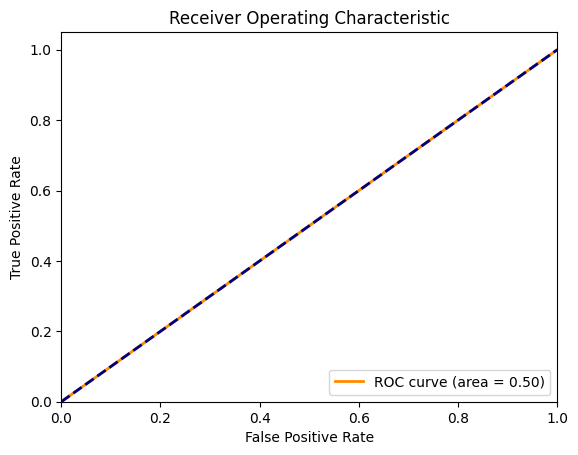

In [31]:
allFeatBestModelPath = "/Users/wachiii/Workschii/brain-mdd/models/CrossValidation/allfeatureCv/Random Forest_SelectKBest/model_fold_7.pkl"
allFeatBestModel = joblib.load(allFeatBestModelPath)


y_testPath = "/Users/wachiii/Workschii/brain-mdd/models/CrossValidation/allfeatureCv/y_test.npy"
x_testPath = "/Users/wachiii/Workschii/brain-mdd/models/CrossValidation/allfeatureCv/X_test.npy"

X_test = np.load(x_testPath)
y_test = np.load(y_testPath)

# do feature selection selectKBest = 100
selector = SelectKBest(score_func=f_classif, k=100)
X_test_selected = selector.fit_transform(X_test, y_test)

y_pred = allFeatBestModel.predict(X_test_selected)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
